In [1]:
import os
from pprint import pprint
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

import pandas as pd
from datetime import datetime
import dateutil.parser
import isodate

from tqdm.auto import tqdm
import math
import sqlite3

from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from langdetect import detect
import re

In [2]:
scopes = ["https://www.googleapis.com/auth/youtube.readonly", 'https://www.googleapis.com/auth/youtube.force-ssl']

In [3]:
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

In [4]:
api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "pipiqi.json"

flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(client_secrets_file, scopes)
credentials = flow.run_console()
youtube = googleapiclient.discovery.build(api_service_name, api_version, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=580286677778-g5veirlu9nrnm83htguojmla73rmsdte.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=nP7q0T3niKaluAK7yFtUEzwgDGSdk8&prompt=consent&access_type=offline
Enter the authorization code: 4/zQEZPNIv0VmkkNA5T76jwIBAXcetcNJhxYRFQ_Fa8H5e1qX5MDmkJmc


### создадим базы данных 

In [5]:
conn = sqlite3.connect('YT.db')
c = conn.cursor()

In [6]:
c.execute("""CREATE TABLE IF NOT EXISTS channel(
    id int PRIMARY KEY, 
    pub_date int, 
    tags text, 
    Co_comm int, 
    Co_l int, 
    Co_dl int, 
    dur text, 
    sec_dur int)""")

c.execute("""CREATE TABLE IF NOT EXISTS comments(
    id int PRIMARY KEY,
    id_video int,
    id_author int,
    textOriginal text,
    totalReplyCount int,
    publishedAt text,
    likeCount int)""")

conn.commit()

### я буду выкачивать много видео через прогон по плейлистам

In [7]:
request = youtube.playlists().list(
    part="contentDetails",
    channelId="UCSPd93is2UQsd_jZ6yHBfqQ",
    maxResults=50
)
response = request.execute()

### тут создадим список с айди плейлистов 

In [8]:
pl_id = []
for i in range(50):
    pl_id.append(response['items'][i]['id'])

### тут создадим список с айди видео 

In [9]:
v_id = []
for p in pl_id:
    request = youtube.playlistItems().list(
        part="contentDetails",
        playlistId=p,
        maxResults=50
    )
    response = request.execute()
    for v in range(len(response['items'])):
        v_id.append(response['items'][v]['contentDetails']['videoId'])

### занесем в дф, потом в бд

In [10]:
to_df = []

for v in v_id[:300]:
    om_v = []
    
    request = youtube.videos().list(
        part="snippet",
        id=v
    )
    response = request.execute()
    om_v.append(response['items'][0]['id'])
    data = response['items'][0]['snippet']
    om_v.append((data['publishedAt']).split('T')[0])
    
    try:
        om_v.append(', '.join(data['tags']))
    except KeyError:
        print('video with id -', v, 'has no tags')
        om_v.append('no tags')
        
    
    request = youtube.videos().list(
        part="statistics",
        id=v
    )
    response = request.execute()
    data = response['items'][0]['statistics']
    om_v.append(data['commentCount'])
    om_v.append(int(data['likeCount']))
    om_v.append(data['dislikeCount'])
    

    request = youtube.videos().list(
        part="contentDetails",
        id=v
    )
    response = request.execute()
    data = response['items'][0]['contentDetails']
    om_v.append(str(isodate.parse_duration(data['duration'])))
    om_v.append(int((isodate.parse_duration(data['duration'])).seconds))
    to_df.append(om_v)

video with id - k4g48wgreMg has no tags
video with id - RGLA_67GltU has no tags


In [11]:
df = pd.DataFrame(to_df, columns=['id', 'pub_date', 'tags', 'Co_comm', 'Co_l', 'Co_dl', 'dur', 'sec_dur'])

In [12]:
df.head()

,id,pub_date,tags,Co_comm,Co_l,Co_dl,dur,sec_dur
0,m06206Bn8iI,2019-07-09,"ПостНаука, postnauka, лекция, наука, откуда бе...",70,910,32,0:03:54,234
1,ZHKT_XU13sI,2017-08-03,"ПостНаука, наука, вирусы, микробиология, ДНК, ...",591,8986,191,0:03:05,185
2,8x5nWBxDdXM,2020-03-03,"постнаука, наука, лекция, postnauka, прямой эф...",937,6005,305,1:04:33,3873
3,38IKheFr8VE,2020-03-26,"постнаука, наука, лекция, postnauka, прямой эф...",824,14139,517,1:53:04,6784
4,kNwMwaNHcv8,2018-12-15,"ПостНаука, postnauka, лекция, наука, вирусолог...",332,4097,84,0:15:08,908


In [13]:
df.to_sql('channel', conn, if_exists='replace')

### а вот и облако слов 

In [14]:
taggiez = []
tags = []
for v in v_id[:300]:
    request = youtube.videos().list(
        part="snippet",
        id=v
    )
    response = request.execute()
    data = response['items'][0]['snippet']
    try:
        taggiez.append(data['tags'])
    except KeyError:
        print('video with id ', v, 'has no tags')

for item in taggiez:
    for i in item:
        if i not in tags:
            tags.append(i)

video with id  k4g48wgreMg has no tags
video with id  RGLA_67GltU has no tags


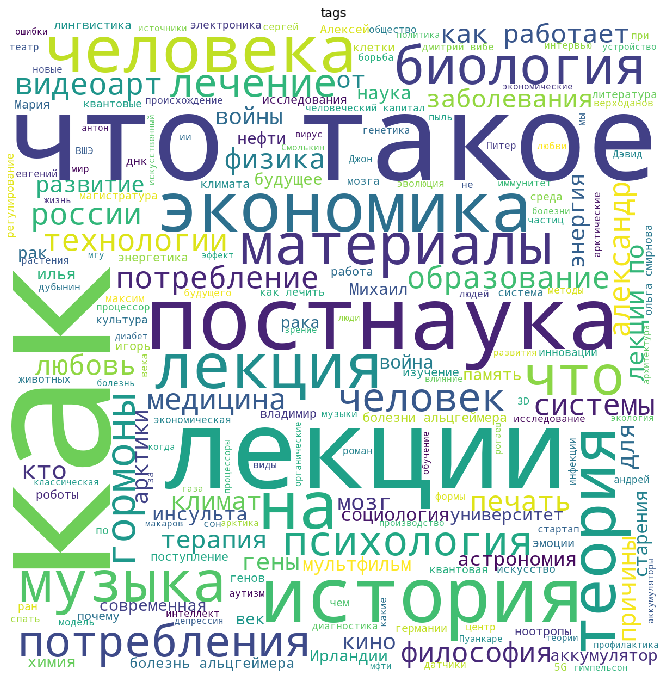

In [15]:
text = ' '.join(tags)

wordcloud = WordCloud(
    background_color ='white',
    width = 1200,
    height = 1200, 
).generate(text)

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('tags')
plt.show()

### визуализация по видео

Text(0.5, 1.0, 'количество лайков по длительности (час:минута:секунда)')

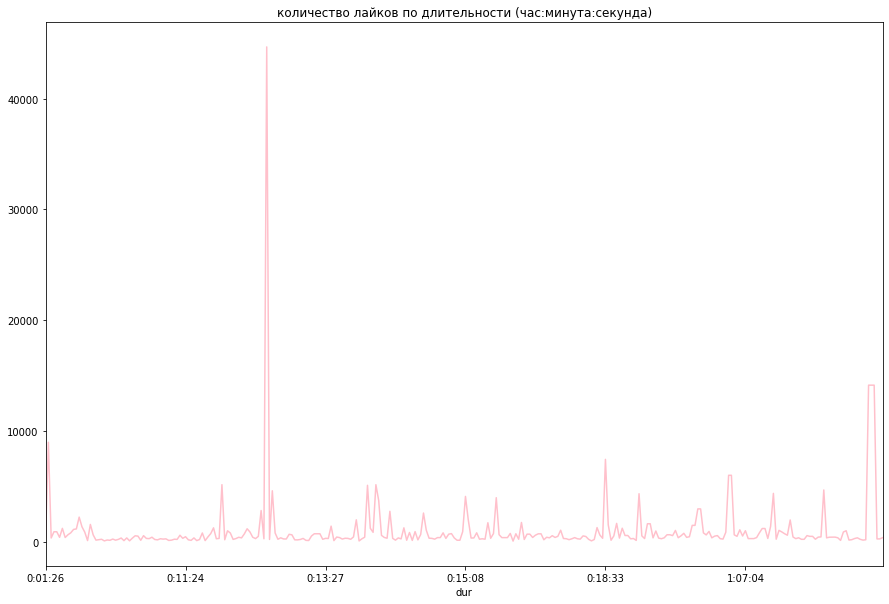

In [16]:
df = pd.DataFrame(to_df, columns=['id', 'pub_date', 'tags', 'Co_comm', 'Co_l', 'Co_dl', 'dur', 'sec_dur']).sort_values('dur')
df = df.set_index('dur')
plt = df.Co_l.plot(figsize=(15, 10), color='pink')
plt.set_title('количество лайков по длительности (час:минута:секунда)')

Text(0.5, 1.0, 'количество лайков по времени')

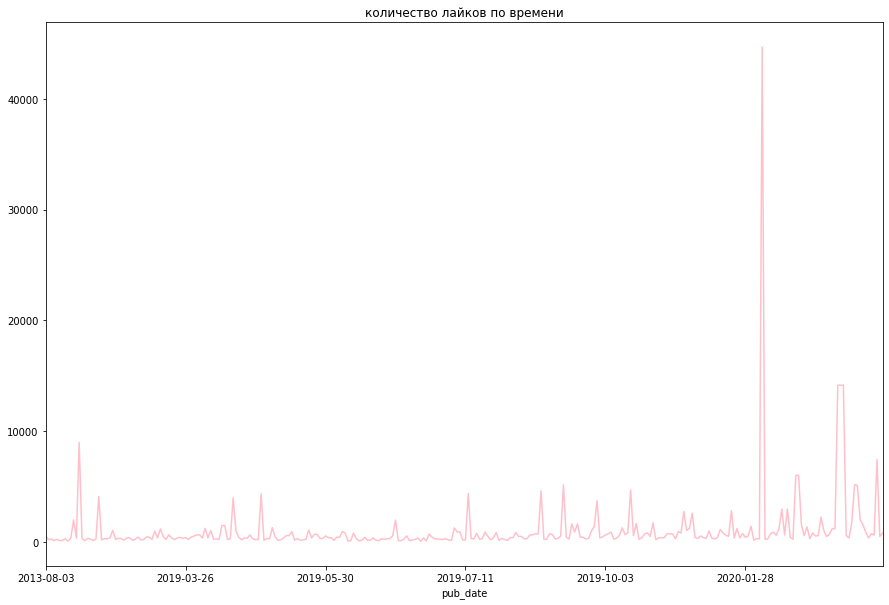

In [17]:
df = pd.DataFrame(to_df, columns=['id', 'pub_date', 'tags', 'Co_comm', 'Co_l', 'Co_dl', 'dur', 'sec_dur']).sort_values('pub_date')
df = df.set_index('pub_date')
plt = df.Co_l.plot(figsize=(15, 10), color='pink')
plt.set_title('количество лайков по времени')

### скачаем комменты

In [18]:
i = 0

page_token = ""

to_df2 = []

textie = []

while i < 1000:
    
    request = youtube.commentThreads().list(
        part="snippet",
        videoId="KQ6zr6kCPj8",
        maxResults=50,
        pageToken= page_token
    )
    response = request.execute()
    
    page_token = response["nextPageToken"]
    
    for item in response['items']:
        comm = []
        comm.append(i)
        comm.append(item['snippet']['videoId'])
        comm.append(item['snippet']['topLevelComment']['snippet']['authorChannelId']['value'])
        comm.append(item['snippet']['topLevelComment']['snippet']['textOriginal'])
        textie.append(item['snippet']['topLevelComment']['snippet']['textOriginal'])
        comm.append(item['snippet']['topLevelComment']['snippet']['likeCount'])
        comm.append((item['snippet']['topLevelComment']['snippet']['publishedAt']).split('T')[0])
        comm.append(item['snippet']['totalReplyCount'])
        
        to_df2.append(comm)
        
        i+=1
        

### создадим дф и бд

In [19]:
df2 = pd.DataFrame(to_df2, columns=['id', 'id_video', 'id_author', 'textOriginal', 'likeCount', 'publishedAt', 'totalReplyCount'])

In [20]:
df2.head()

,id,id_video,id_author,textOriginal,likeCount,publishedAt,totalReplyCount
0,0,KQ6zr6kCPj8,UCwWJQzpPUtNPxyKue3UXEMQ,when everyone gets out of quarantine:,2,2020-04-29,0
1,1,KQ6zr6kCPj8,UCcPJruHWkBtiYH03nZkl9lg,Like si no tienes nada que hacer en la cuarent...,0,2020-04-29,0
2,2,KQ6zr6kCPj8,UConJcv7t4toO8haEZ0tqZPw,wena cancion lo dos,0,2020-04-29,0
3,3,KQ6zr6kCPj8,UC4oW-OA3ri8TAIECKmRrMzg,"Ah yes, how I miss the long ass intro.",0,2020-04-29,0
4,4,KQ6zr6kCPj8,UCXbBx337ctMK-hIV1fNQPqg,OMG THE JAKET OF LMFAO,1,2020-04-29,0


In [21]:
df2.to_sql('comments', conn, if_exists='replace')

conn.close()

### посмотрим на комменты

In [22]:
ar = []
en = [] 
ru = []

for item in textie:
    try:
        if detect(item) == 'ar':
            ar.append(item)
        if detect(item) == 'en':
            en.append(item)
        if detect(item) == 'ru':
            ru.append(item)
    except:
        continue

In [23]:
for sent in en:
    words = sent.split()
    av_en = sum(len(word) for word in words) / len(words)
    
for sent in ru:
    words = sent.split()
    av_ru = sum(len(word) for word in words) / len(words)
    
for sent in ar:
    words = sent.split()
    av_ar = sum(len(word) for word in words) / len(words)
    
print('средняя длина слова среди арабских комментов -', av_ar)
print('средняя длина слова среди английских комментов -', av_en)
print('средняя длина слова среди русских комментов -', av_ru)

средняя длина слова среди арабских комментов - 4.333333333333333
средняя длина слова среди английских комментов - 5.166666666666667
средняя длина слова среди русских комментов - 4.454545454545454


#### так вышло, что этот клип похож на ощущения тусовщиков после карантина, поэтому глянем сколько раз он был упомянут в комментах на английском языке

In [36]:
import string

In [44]:
quarantine = 0
for s in en:
    sent = s.lower()
    words = sent.split()
    for w in words:
        word = w.rstrip(string.punctuation).lstrip(string.punctuation)
        if word == 'quarantine':
            quarantine +=1
print('слово "quarantine" было упомянуто ', quarantine, 'раз')

слово "quarantine" было упомянуто  38 раз
